In [ ]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

# Try to import graphviz, fallback if not available
try:
    import graphviz
    GRAPHVIZ_AVAILABLE = True
    print("Graphviz available - full visualizations enabled")
except ImportError:
    GRAPHVIZ_AVAILABLE = False
    print("Graphviz not available - using matplotlib fallback")

print("All imports successful!")

✓ Graphviz available - full visualizations enabled
All imports successful!


In [17]:
def create_mock_circuit_data():
    """Create mock circuit discovery data for testing"""
    # Simulate circuit edges between model components
    edges = [
        ('input', 'attn_0_head_0', 0.8),
        ('input', 'attn_0_head_1', 0.6),
        ('attn_0_head_0', 'mlp_0', 0.7),
        ('attn_0_head_1', 'mlp_0', 0.5),
        ('mlp_0', 'attn_1_head_0', 0.9),
        ('attn_1_head_0', 'output', 0.85),
        ('mlp_0', 'output', 0.4),
    ]

    # Create two versions to compare stability
    circuit_v1 = {
        'edges': edges,
        'threshold': 0.5
    }

    # Slightly perturbed version
    np.random.seed(42)  # For reproducible results
    edges_v2 = [(src, dst, weight + np.random.normal(0, 0.1))
                for src, dst, weight in edges]
    circuit_v2 = {
        'edges': edges_v2,
        'threshold': 0.5
    }

    return circuit_v1, circuit_v2

def filter_circuit_by_threshold(circuit, threshold=0.5):
    """Filter circuit edges by importance threshold"""
    filtered_edges = [(src, dst, weight) for src, dst, weight in circuit['edges']
                    if abs(weight) >= threshold]
    return filtered_edges

print("Data generation functions defined!")

Data generation functions defined!


In [20]:
def calculate_circuit_stability(circuit1, circuit2):
    """Calculate stability metrics between two circuits"""
    edges1 = set((src, dst) for src, dst, _ in filter_circuit_by_threshold(circuit1))
    edges2 = set((src, dst) for src, dst, _ in filter_circuit_by_threshold(circuit2))

    # Jaccard similarity
    intersection = len(edges1.intersection(edges2))
    union = len(edges1.union(edges2))
    jaccard = intersection / union if union > 0 else 0

    # Edge overlap
    overlap = intersection / max(len(edges1), len(edges2)) if max(len(edges1), len(edges2)) > 0 else 0

    return {
        'jaccard_similarity': jaccard,
        'edge_overlap': overlap,
        'edges_v1': len(edges1),
        'edges_v2': len(edges2),
        'shared_edges': intersection
    }

def analyze_edge_weights(circuit1, circuit2):
    """Analyze weight differences between circuits"""
    edges1 = {(src, dst): weight for src, dst, weight in circuit1['edges']}
    edges2 = {(src, dst): weight for src, dst, weight in circuit2['edges']}

    weight_diffs = []
    for edge in edges1:
        if edge in edges2:
            diff = abs(edges1[edge] - edges2[edge])
            weight_diffs.append(diff)

    return {
        'mean_weight_diff': np.mean(weight_diffs) if weight_diffs else 0,
        'max_weight_diff': np.max(weight_diffs) if weight_diffs else 0,
        'std_weight_diff': np.std(weight_diffs) if weight_diffs else 0
    }

print("Analysis functions defined!")

Analysis functions defined!


In [21]:
def visualize_circuit_matplotlib(circuit, name="circuit", ax=None):
    """Create matplotlib visualization of circuit"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Filter edges by threshold
    edges = filter_circuit_by_threshold(circuit)

    # Create networkx graph
    G = nx.DiGraph()
    for src, dst, weight in edges:
        G.add_edge(src, dst, weight=weight)

    # Position nodes
    pos = nx.spring_layout(G, k=2, iterations=50)

    # Draw nodes with colors by type
    node_colors = []
    for node in G.nodes():
        if 'input' in node:
            node_colors.append('lightblue')
        elif 'output' in node:
            node_colors.append('lightcoral')
        elif 'attn' in node:
            node_colors.append('lightgreen')
        elif 'mlp' in node:
            node_colors.append('lightyellow')
        else:
            node_colors.append('white')

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                        node_size=2000, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Draw edges with weights
    for src, dst, weight in edges:
        nx.draw_networkx_edges(G, pos, [(src, dst)],
                            edge_color='red' if weight < 0 else 'blue',
                            width=abs(weight) * 3, ax=ax)

    # Add edge labels
    edge_labels = {(src, dst): f'{weight:.2f}' for src, dst, weight in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6, ax=ax)

    ax.set_title(f'Circuit {name}')
    ax.axis('off')

    return ax

def create_comparison_matplotlib(circuit1, circuit2, stability_metrics):
    """Create side-by-side comparison with matplotlib"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Plot both circuits
    visualize_circuit_matplotlib(circuit1, "V1", ax1)
    visualize_circuit_matplotlib(circuit2, "V2", ax2)

    # Plot stability metrics
    metrics = list(stability_metrics.keys())
    values = list(stability_metrics.values())

    ax3.bar(range(len(metrics)), values)
    ax3.set_xticks(range(len(metrics)))
    ax3.set_xticklabels([m.replace('_', '\n') for m in metrics], rotation=45)
    ax3.set_title('Stability Metrics')
    ax3.set_ylabel('Value')

    plt.tight_layout()
    plt.show()

    return fig

print("Matplotlib visualization functions defined!")

Matplotlib visualization functions defined!


In [ ]:
def visualize_circuit_graphviz(circuit, name="circuit", output_dir="./"):
  """Create Graphviz visualization of circuit (if available)"""
  if not GRAPHVIZ_AVAILABLE:
    print("Graphviz not available, skipping...")
    return None

  dot = graphviz.Digraph(comment=f'Circuit {name}')
  dot.attr(rankdir='TB')

  # Filter edges by threshold
  edges = filter_circuit_by_threshold(circuit)

  # Add nodes and edges
  nodes = set()
  for src, dst, weight in edges:
    nodes.add(src)
    nodes.add(dst)

  # Style nodes by type
  for node in nodes:
    if 'input' in node:
        dot.node(node, style='filled', fillcolor='lightblue')
    elif 'output' in node:
        dot.node(node, style='filled', fillcolor='lightcoral')
    elif 'attn' in node:
        dot.node(node, style='filled', fillcolor='lightgreen')
    elif 'mlp' in node:
        dot.node(node, style='filled', fillcolor='lightyellow')
    else:
        dot.node(node)

  # Add edges with weights
  for src, dst, weight in edges:
    color = 'red' if weight < 0 else 'blue'
    width = str(abs(weight) * 3)
    dot.edge(src, dst, label=f'{weight:.2f}', color=color, penwidth=width)

  # Save visualization
  output_path = Path(output_dir) / f'{name}_circuit'
  dot.render(output_path, format='png', cleanup=True)
  print(f"Circuit visualization saved to: {output_path}.png")

  return dot

print("Graphviz functions defined (if available)!")

Graphviz functions defined (if available)!


In [24]:
print("=== Circuit Stability Test ===")

# Generate mock circuit data
print("1. Generating mock circuit data...")
circuit1, circuit2 = create_mock_circuit_data()

print(f"Circuit 1 has {len(circuit1['edges'])} edges")
print(f"Circuit 2 has {len(circuit2['edges'])} edges")

# Display first few edges from each circuit
print("\nCircuit 1 edges:")
for src, dst, weight in circuit1['edges'][:3]:
	print(f"  {src} -> {dst}: {weight:.3f}")

print("\nCircuit 2 edges:")
for src, dst, weight in circuit2['edges'][:3]:
	print(f"  {src} -> {dst}: {weight:.3f}")

=== Circuit Stability Test ===
1. Generating mock circuit data...
Circuit 1 has 7 edges
Circuit 2 has 7 edges

Circuit 1 edges:
  input -> attn_0_head_0: 0.800
  input -> attn_0_head_1: 0.600
  attn_0_head_0 -> mlp_0: 0.700

Circuit 2 edges:
  input -> attn_0_head_0: 0.850
  input -> attn_0_head_1: 0.586
  attn_0_head_0 -> mlp_0: 0.765


In [25]:
print("2. Calculating stability metrics...")

# Basic stability metrics
stability = calculate_circuit_stability(circuit1, circuit2)
weight_analysis = analyze_edge_weights(circuit1, circuit2)

print("\nStability Results:")
for metric, value in stability.items():
	print(f"  {metric}: {value:.3f}")

print("\nWeight Analysis:")
for metric, value in weight_analysis.items():
	print(f"  {metric}: {value:.3f}")

2. Calculating stability metrics...

Stability Results:
  jaccard_similarity: 0.857
  edge_overlap: 0.857
  edges_v1: 6.000
  edges_v2: 7.000
  shared_edges: 6.000

Weight Analysis:
  mean_weight_diff: 0.069
  max_weight_diff: 0.158
  std_weight_diff: 0.057


3. Creating visualizations...
Creating matplotlib visualization...


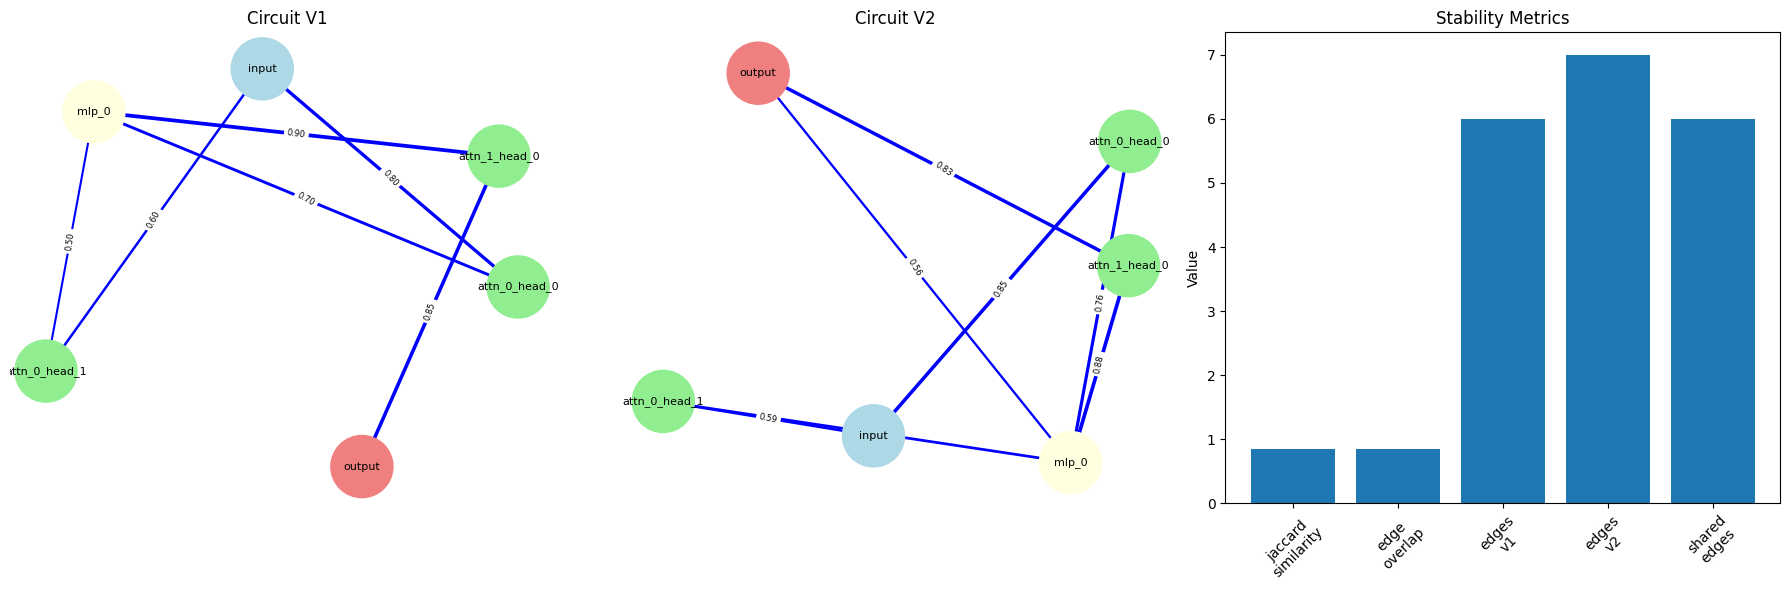

Creating graphviz visualizations...
Circuit visualization saved to: v1_circuit.png
Circuit visualization saved to: v2_circuit.png


In [26]:
print("3. Creating visualizations...")

# Matplotlib visualization (always available)
print("Creating matplotlib visualization...")
create_comparison_matplotlib(circuit1, circuit2, stability)

# Graphviz visualization (if available)
if GRAPHVIZ_AVAILABLE:
	print("Creating graphviz visualizations...")
	visualize_circuit_graphviz(circuit1, "v1")
	visualize_circuit_graphviz(circuit2, "v2")

In [28]:
print("=== Summary ===")
print(f"Jaccard Similarity: {stability['jaccard_similarity']:.3f}")
print(f"Edge Overlap: {stability['edge_overlap']:.3f}")
print(f"Mean Weight Difference: {weight_analysis['mean_weight_diff']:.3f}")

# Interpretation
if stability['jaccard_similarity'] > 0.7:
	print("✓ Circuits are highly stable")
elif stability['jaccard_similarity'] > 0.4:
	print("~ Circuits are moderately stable")
else:
	print("✗ Circuits show low stability")

print("\n=== Test Complete ===")

=== Summary ===
Jaccard Similarity: 0.857
Edge Overlap: 0.857
Mean Weight Difference: 0.069
✓ Circuits are highly stable

=== Test Complete ===


Generated circuit visualizations:


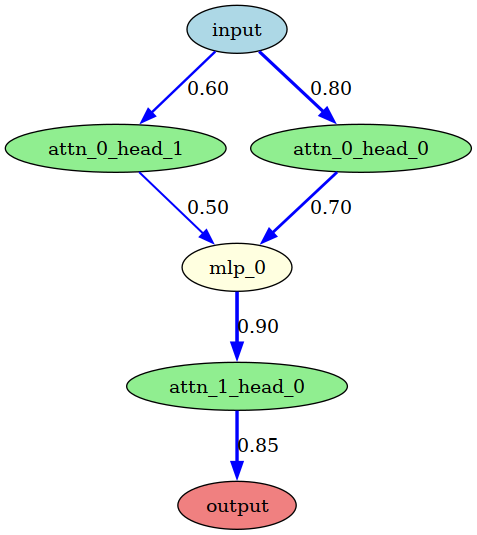

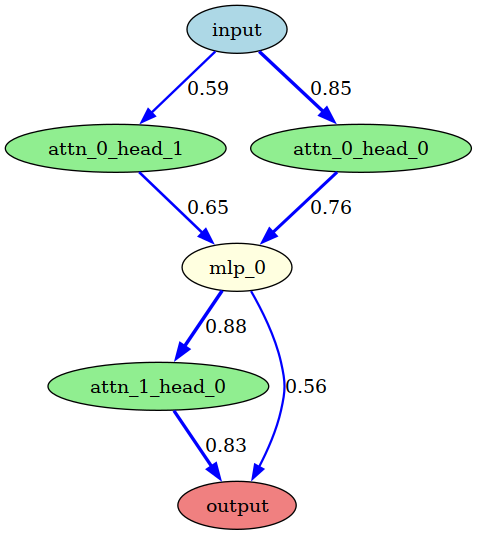

In [29]:
if GRAPHVIZ_AVAILABLE:
	from IPython.display import Image, display

	# Display generated images
	try:
		print("Generated circuit visualizations:")
		display(Image('v1_circuit.png'))
		display(Image('v2_circuit.png'))
	except FileNotFoundError:
		print("No PNG files found - visualization may have failed")